In [3]:
import os
os.chdir('../../..')

In [4]:
import convokit
from convokit import TextParser, TensorDecomposer, Corpus, download

In [5]:
corpus = Corpus(download('switchboard-corpus'))

Dataset already exists at /Users/calebchiam/.convokit/downloads/switchboard-corpus


In [6]:
corpus.print_summary_stats()

Number of Speakers: 440
Number of Utterances: 122646
Number of Conversations: 1155


In [7]:
utt_df = corpus.get_utterances_dataframe()

In [8]:
utt_df.head()

,timestamp,text,speaker,reply_to,conversation_id,meta.tag
id,,,,,,
4325-0,None,"Okay. /{D So, }",1519,None,4325-0,"[[Okay. /, o], [{D So, }, qw]]"
4325-1,None,"[ [ I guess, +",1632,4325-0,4325-0,"[[[ [ I guess, +, qy^d]]"
4325-2,None,"What kind of experience [ do you, + do you ] h...",1519,4325-1,4325-0,"[[What kind of experience [ do you, + do you ]..."
4325-3,None,"I think, ] + {F uh, } I wonder ] if that worke...",1632,4325-2,4325-0,"[[I think, ] + {F uh, } I wonder ] if that wor..."
4325-4,None,Does it say something? /,1519,4325-3,4325-0,"[[Does it say something? /, qy]]"


In [9]:
for convo in corpus.iter_conversations():
    if not convo.check_integrity(verbose=False):
        print(convo.id)

In [10]:
import regex as re
def damsl_act_tag(tag):
    """
    Seeks to duplicate the tag simplification described at the
    Coders' Manual: http://www.stanford.edu/~jurafsky/ws97/manual.august1.html
    """
    d_tags = []
    tags = re.split(r"\s*[,;]\s*", tag)
    for tag in tags:
        if tag in ('qy^d', 'qw^d', 'b^m'): pass
        elif tag == 'nn^e': tag = 'ng'
        elif tag == 'ny^e': tag = 'na'
        else: 
            tag = re.sub(r'(.)\^.*', r'\1', tag)
            tag = re.sub(r'[\(\)@*]', '', tag)            
            if tag in ('qr', 'qy'):                         tag = 'qy'
            elif tag in ('fe', 'ba'):                       tag = 'ba'
            elif tag in ('oo', 'co', 'cc'):                 tag = 'oo_co_cc'
            elif tag in ('fx', 'sv'):                       tag = 'sv'
            elif tag in ('aap', 'am'):                      tag = 'aap_am'
            elif tag in ('arp', 'nd'):                      tag = 'arp_nd'
            elif tag in ('fo', 'o', 'fw', '"', 'by', 'bc'): tag = 'fo_o_fw_"_by_bc'            
        d_tags.append(tag)
    # Dan J says (p.c.) that it makes sense to take the first;
    # there are only a handful of examples with 2 tags here.
    return d_tags

In [11]:
from functools import reduce

In [12]:
for utt in corpus.iter_utterances():
    utt.meta['DAMSL_tags'] = set(reduce(lambda a, b: a+b, [damsl_act_tag(x[1]) for x in utt.meta['tag']]))

In [13]:
damsl_tags = set()
for utt in corpus.iter_utterances():
    damsl_tags = damsl_tags.union(utt.meta['DAMSL_tags'])

In [14]:
len(damsl_tags)

43

In [15]:
DAMSL_dict = {'%': 'uninterpretable',
 '+': 'interrupted',
 '^2': 'collaborative completion',
 '^g': 'tag-question',
 '^h': 'hold before answer/agreement',
 '^q': 'quotation',
 'aa': 'agree/accept',
 'aap_am': 'maybe/accept-part',
 'ad': 'action-directive',
 'ar': 'reject',
 'arp_nd': 'dispreferred answers',
 'b': 'acknowledge (backchannel)',
 'b^m': 'repeat-phrase',
 'ba': 'appreciation',
 'bd': 'downplayer',
 'bf': 'summarize/reformulate',
 'bh': 'backchannel in question form',
 'bk': 'response acknowledgment',
 'br': 'signal-non-understanding',
 'fa': 'apology',
 'fc': 'conventional-closing',
 'fo_o_fw_"_by_bc': 'other',
 'fp': 'conventional-opening',
 'ft': 'thanking',
 'h': 'hedge',
 'na': 'affirmative non-yes answers',
 'ng': 'negative non-no answers',
 'nn': 'no answers',
 'no': 'other answers',
 'ny': 'yes answers',
 'oo_co_cc': 'offers, options, commits',
 'qh': 'rhetorical-questions',
 'qo': 'open-question',
 'qrr': 'or-clause',
 'qw': 'wh-question',
 'qw^d': 'declarative wh-question',
 'qy': 'yes-no-question',
 'qy^d': 'declarative yes-no-question',
 'sd': 'statement-non-opinion',
 'sv': 'statement-opinion',
 't1': 'self-talk',
 't3': '3rd-party-talk',
 'x': 'non-verbal'}

In [16]:
for utt in corpus.iter_utterances():
    d = {k: 0 for k in DAMSL_dict}
    for tag in utt.meta['DAMSL_tags']:
        d[tag] = 1
    utt.meta['DAMSL_dict'] = d

In [17]:
for convo in corpus.iter_conversations():
    convo.meta['length'] = len(list(convo.iter_utterances()))

In [18]:
convo_df = corpus.get_conversations_dataframe()

In [19]:
min(convo_df['meta.length'])

15

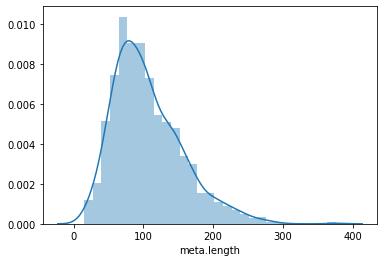

In [20]:
import seaborn as sns

sns.distplot(convo_df['meta.length'])

In [23]:
def convo_sufficient_length(l):
    return lambda convo: convo.meta['length'] >= l

l = 50

In [24]:
for convo in corpus.iter_conversations(convo_sufficient_length(l)):
    for idx, utt in enumerate(list(convo.traverse('dfs'))[:l]):
        convo.meta['DAMSL-dict-{}'.format(idx+1)] = utt.meta['DAMSL_dict']

In [25]:
td = TensorDecomposer(feature_set=['DAMSL-dict-{}'.format(idx) for idx in range(1, l+1)], 
                      obj_type="conversation", tensor_func='tensortools-ncp-bcd', rank=10,
                     )

In [27]:
td.fit(corpus, selector=convo_sufficient_length(l))

Constructing tensor...Done.
Decomposing tensor...NCP_BCD: iteration 1, objective 0.9076093483755179, improvement inf.
NCP_BCD: iteration 2, objective 0.8980745055727956, improvement 0.009534842802722321.
NCP_BCD: iteration 3, objective 0.8954165892181362, improvement 0.0026579163546593954.
NCP_BCD: iteration 4, objective 0.8934510929657099, improvement 0.0019654962524262576.
NCP_BCD: iteration 5, objective 0.8917571851693779, improvement 0.0016939077963320504.
NCP_BCD: iteration 6, objective 0.8900885097797715, improvement 0.0016686753896063555.
NCP_BCD: iteration 7, objective 0.8883144707079229, improvement 0.0017740390718485877.
NCP_BCD: iteration 8, objective 0.8864769358394586, improvement 0.0018375348684642745.
NCP_BCD: iteration 9, objective 0.8846491117264776, improvement 0.0018278241129809913.
NCP_BCD: iteration 10, objective 0.8828252955082312, improvement 0.0018238162182464546.
NCP_BCD: iteration 11, objective 0.8810504382070683, improvement 0.001774857301162891.
NCP_BCD: ite

NCP_BCD: iteration 94, objective 0.84914529040476, improvement 1.5436462988072108e-05.
NCP_BCD: iteration 95, objective 0.8491293897946939, improvement 1.5900610066066356e-05.
NCP_BCD: iteration 96, objective 0.8491129850949255, improvement 1.640469976837977e-05.
NCP_BCD: iteration 97, objective 0.8490962837055244, improvement 1.6701389401130307e-05.
NCP_BCD: iteration 98, objective 0.8490793500768555, improvement 1.6933628668835965e-05.
NCP_BCD: iteration 99, objective 0.8490621034336147, improvement 1.724664324087577e-05.
NCP_BCD: iteration 100, objective 0.8490439365262408, improvement 1.8166907373884378e-05.
NCP_BCD: iteration 101, objective 0.8490241251865063, improvement 1.9811339734499e-05.
NCP_BCD: iteration 102, objective 0.8490019996077245, improvement 2.2125578781784228e-05.
NCP_BCD: iteration 103, objective 0.8489771072328796, improvement 2.4892374844931453e-05.
NCP_BCD: iteration 104, objective 0.8489479528765451, improvement 2.9154356334437637e-05.
NCP_BCD: iteration 105,

Directory already exists. Exiting summarize()


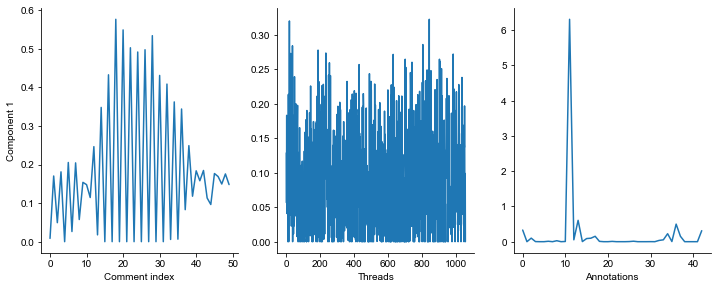

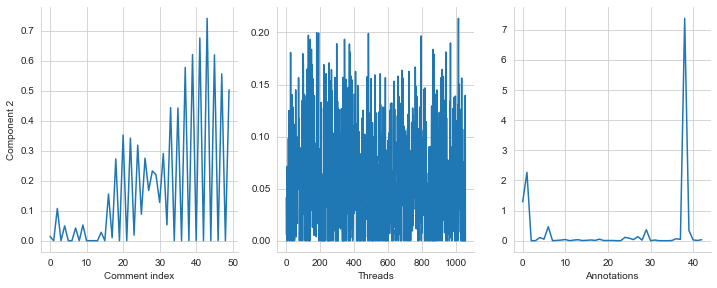

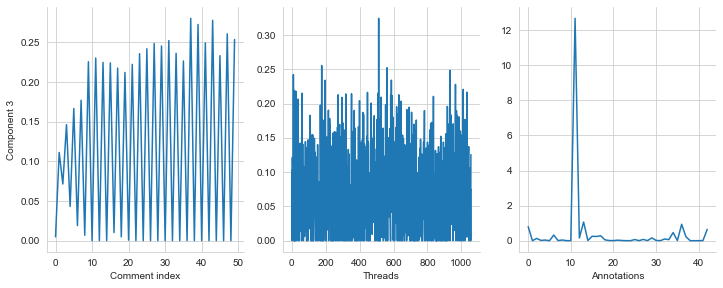

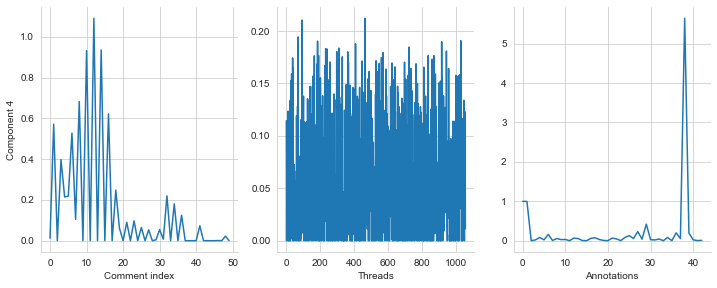

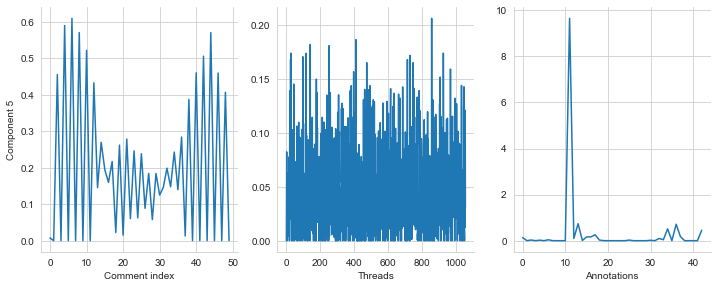

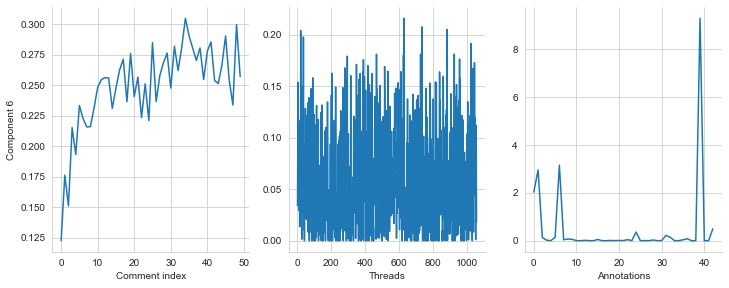

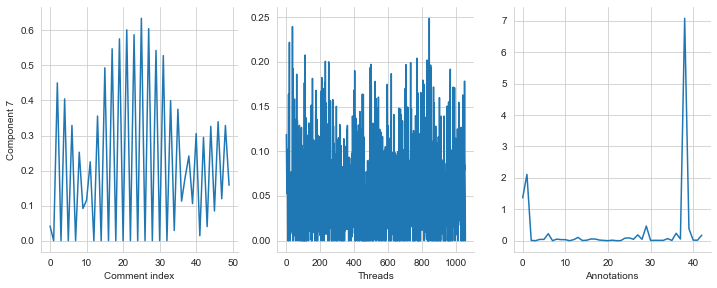

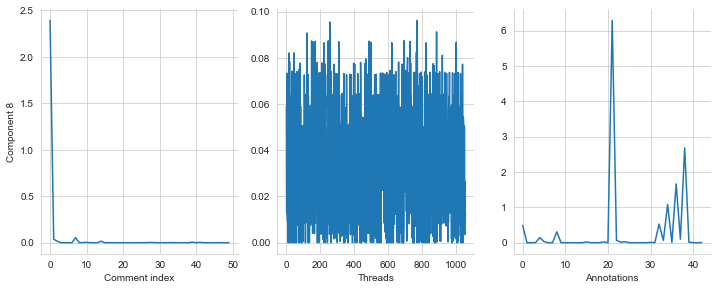

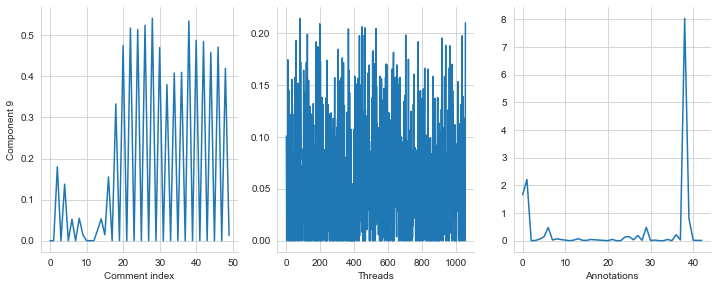

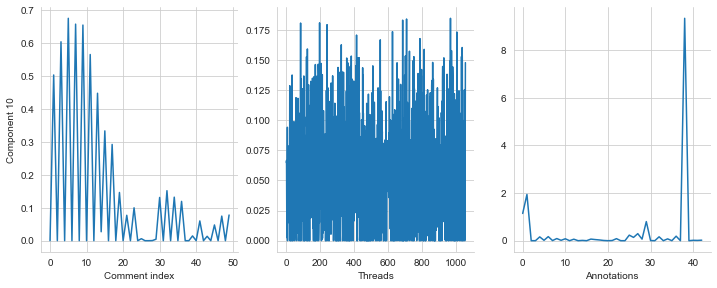

In [28]:
td.summarize(corpus, axis_names=['Comment index', 'Threads', 'Annotations'], 
             output_dir='convokit/tensor_decomposer/reports/coarse-discourse', 
             report_title='Coarse discourse', 
             liwc=True)

In [30]:
ts = []
for utt in corpus.iter_utterances():
    ts.extend(utt.meta['DAMSL_tags'])

In [36]:
from collections import Counter
ctr = Counter(ts)

[(k, v) for (k, v) in sorted(list(ctr.items()), key=lambda x: x[1], reverse=True)]

[('sd', 41254),
 ('b', 35666),
 ('sv', 18811),
 ('+', 17595),
 ('%', 13500),
 ('aa', 8504),
 ('ba', 4532),
 ('qy', 4479),
 ('x', 3610),
 ('ny', 2708),
 ('qw', 1912),
 ('fc', 1544),
 ('bk', 1242),
 ('qy^d', 1184),
 ('nn', 1183),
 ('h', 1152),
 ('bh', 1047),
 ('bf', 908),
 ('fo_o_fw_"_by_bc', 858),
 ('na', 805),
 ('^2', 710),
 ('b^m', 680),
 ('^q', 669),
 ('ad', 667),
 ('qo', 637),
 ('qh', 518),
 ('^h', 492),
 ('br', 298),
 ('ng', 295),
 ('ar', 294),
 ('no', 271),
 ('qrr', 207),
 ('arp_nd', 196),
 ('fp', 176),
 ('oo_co_cc', 102),
 ('aap_am', 99),
 ('t1', 97),
 ('^g', 92),
 ('bd', 89),
 ('qw^d', 80),
 ('fa', 79),
 ('ft', 77),
 ('t3', 69)]

In [31]:
from convokit import Classifier
import numpy as np
from convokit import BoWClassifier

In [32]:
long_8 = lambda convo: convo.meta['longest_path'] >= 8

In [33]:
for convo in corpus.iter_conversations(long_8):
    utts = convo.get_chronological_utterance_list()
    convo.meta['ends_disg'] = utts[6].meta['disagreement'] or utts[7].meta['disagreement']

### Tensor classifier

In [150]:
td.transform(corpus, selector=long_8)

In [151]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
model = Pipeline([("standardScaler", StandardScaler(with_mean=False)),
                            ("logreg", LogisticRegression(solver='liblinear'))])

In [152]:
clf_tensor = BoWClassifier(obj_type="conversation", vector_name='tensor_factor', 
                           labeller=lambda convo: convo.meta['ends_disg'],
                clf_feat_name='tensor-pred', clf_prob_feat_name='tensor-pred-score',
                           clf=model
                )

In [153]:
kfold = KFold(n_splits=20, shuffle=True)

In [154]:
res = clf_tensor.evaluate_with_cv(corpus, selector=long_8, cv=kfold)

Using corpus objects...

Running a cross-validated evaluation...
Done.


In [156]:
np.mean(res)

0.8126596980255517

In [39]:
ctr = 0
for convo in corpus.iter_conversations(long_8):
    ctr += int(convo.meta['ends_disg'])

In [40]:
base_accuracy = 1 - ctr / 838
base_accuracy

0.7601431980906921

In [41]:
clf_tensor.fit(corpus, selector=long_8)

In [42]:
clf_tensor.get_model().named_steps['logreg']

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
clf_tensor.get_coefs([f'component{idx}' for idx in range(1, 20+1)])

AssertionError: 

### Concat

In [43]:
for convo in corpus.iter_conversations(long_8):
    convo.meta['concat'] = dict()
    for idx in range(1, 6+1):
        d = convo.meta['annot-dict-{}'.format(idx)].copy()
        convo.meta['concat'].update({k+"_"+str(idx): v for k, v in d.items()})

In [131]:
from sklearn.preprocessing import scale

def scale_by_comment_idx(tensor):
    tensor = tensor.copy()
    for i in range(tensor.shape[0]):
        tensor[0, :, :] = scale(tensor[0, :, :])
    return tensor

In [132]:
clf = Classifier(obj_type="conversation", pred_feats=['concat'], labeller=lambda convo: convo.meta['ends_disg'],
                clf_feat_name='concat-pred', clf_prob_feat_name='concat-pred-score', clf=model
                )

In [133]:
res = clf.evaluate_with_cv(corpus, selector=long_8, cv=kfold)

Using corpus objects...
Running a cross-validated evaluation...
Done.


In [134]:
np.mean(res)

0.810191637630662

### +PCA

In [66]:
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
fold5 = KFold(10, True)

In [49]:
from convokit import extract_feats_and_label
X, y = extract_feats_and_label(corpus, "conversation", ['concat'], lambda x: x.meta['ends_disg'], long_8)

In [50]:
convo_ids = [convo.id for convo in corpus.iter_conversations(long_8)]

In [145]:
results = []
for train, test in kfold.split(X, y):
    pca = PCA(n_components=20)
    model.fit(pca.fit_transform(X[train].toarray()), y[train])
    pred = model.predict(pca.transform(X[test].toarray()))
    results.append(np.mean(pred == y[test]))
#     print(np.mean(clf.predict(X[test].toarray()) == y[test]))

In [146]:
np.mean(results)

0.8127177700348434

### Averaged

In [102]:
for convo in corpus.iter_conversations(long_8):
    convo.meta['avg'] = convo.meta['annot-dict-1'].copy()
    for idx in range(2, 6+1):
        d = convo.meta['annot-dict-{}'.format(idx)]
        for k, v in d.items():
            convo.meta['avg'][k] += v
    for k, v in convo.meta['avg'].items():
        convo.meta['avg'][k] = v / 6

In [103]:
clf_avg = Classifier(obj_type="conversation", pred_feats=['avg'], labeller=lambda convo: convo.meta['ends_disg'],
                clf_feat_name='avg-pred', clf_prob_feat_name='avg-pred-score', clf=model
                )

In [105]:
res = clf_avg.evaluate_with_cv(corpus, selector=long_8, cv=kfold)

Using corpus objects...
Running a cross-validated evaluation...
Done.


In [106]:
np.mean(res)

0.7995934959349593

In [ ]:
input()

In [ ]:
disgmt_convos = []
for idx, convo in enumerate(corpus.iter_conversations(lambda convo: convo.meta['longest_path'] >= 8)):
    if convo.get_chronological_utterance_list()[7].meta['disagreement'] == 1:
        disgmt_convos.append(idx)

In [ ]:
disgmt_convos = set(disgmt_convos)

In [ ]:
import seaborn as sns
import numpy as np

In [ ]:
td.thread_anomaly_threshold = 1.5

In [ ]:
len(disgmt_convos) / 838

In [ ]:
for idx in range(9):
    pos_threads =set(td._get_anomalous_points(td.factors[1], idx, td.thread_anomaly_threshold)[0])
    print(f"Component: {idx+1}, Occurrence rate: {len(pos_threads & disgmt_convos) / len(pos_threads)}")

In [ ]:
np.mean(td.factors[1], axis=0)

In [ ]:
np.mean(td.factors[1][list(disgmt_convos)], axis=0)

In [ ]:
np.mean(td.factors[1][list(set(list(range(838))) - disgmt_convos)], axis=0)

In [ ]:
import pandas as pd 
df = pd.DataFrame()

In [ ]:
collective = {i+1: v for i, v in enumerate(np.mean(td.factors[1], axis=0))}

In [ ]:
disgmt_only = {i+1: v for i, v in enumerate(np.mean(td.factors[1][list(disgmt_convos)], axis=0))}

In [ ]:
non_disgmt = {i+1: v for i, v in enumerate(np.mean(td.factors[1][list(set(list(range(838))) - disgmt_convos)], axis=0))}

In [ ]:
pd.DataFrame({'collective': collective, 'disagreement': disgmt_only, 'non-disagreement': non_disgmt})

In [ ]:
sns.distplot(td_disgmt.factors[1][:, 1])

In [ ]:
sns.distplot(td_disgmt.factors[1][:, 2])

In [ ]:
arr0 = td_disgmt.factors[1][:, 0]
arr1 = td_disgmt.factors[1][:, 1]
arr2 = td_disgmt.factors[1][:, 2]

In [ ]:
arr0[27]

In [ ]:
start_index = 55
arr0_top = set(list(np.argsort(arr0)[-start_index:]))
arr1_top = set(list(np.argsort(arr1)[-start_index:]))
arr2_top = set(list(np.argsort(arr2)[-start_index:]))

In [ ]:
# appears in all three
len(arr0_top & arr1_top & arr2_top)

In [ ]:
convo_df_subset = corpus.get_conversations_dataframe(selector=lambda convo: convo.meta['longest_path'] >= 8 and 
              convo.get_chronological_utterance_list()[7].meta['disagreement'] == 1)

In [ ]:
for idx in (arr0_top & arr1_top & arr2_top):
    convo_id = convo_df_subset.iloc[idx].name
    corpus.get_conversation(convo_id).print_conversation_structure(lambda utt: str(utt.meta['disagreement']), limit=8)

In [ ]:
len(arr0_top - (arr1_top | arr2_top))

In [ ]:
for idx in (arr0_top - (arr1_top | arr2_top)):
    convo_id = convo_df_subset.iloc[idx].name
    corpus.get_conversation(convo_id).print_conversation_structure(lambda utt: str(utt.meta['disagreement']), limit=8)

In [ ]:
len(arr2_top - (arr0_top | arr1_top))

In [ ]:
for idx in (arr2_top - (arr0_top | arr1_top)):
    convo_id = convo_df_subset.iloc[idx].name
    corpus.get_conversation(convo_id).print_conversation_structure(lambda utt: str(utt.meta['disagreement']), limit=8)

In [ ]:
len(arr2_top & arr1_top)

In [ ]:
np.argwhere(arr2 >= np.quantile(td_disgmt.factors[2][:, 1], q=0.66)).flatten()

### Emphasizing disagreements

In [ ]:
corpus.random_utterance()

In [ ]:
annotation_types = ['agreement',
                     'announcement',
                     'answer',
                     'appreciation',
                     'disagreement',
                     'elaboration',
                     'humor',
                     'negativereaction',
                     'other',
                     'question']

In [ ]:
no_maj = 0
no_maj_types = {t: 0 for t in annotation_types}
for utt in corpus.iter_utterances():
    if utt.meta['majority_type'] is None:
        no_maj += 1
        for t in utt.meta['annotation-types']:
            no_maj_types[t] += 1

In [ ]:
for t in no_maj_types:
    no_maj_types[t] /= 3961

In [ ]:
no_maj_types

In [ ]:
no_maj_elab / no_maj

In [ ]:
no_maj

### TSNE

In [ ]:
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=2000, verbose=1)

In [ ]:
type_to_trunc = {
    'agreement': 'agmt',
    'announcement': 'anc',
    'answer': 'ans',
    'appreciation': 'appr',
    'disagreement': 'dsgmt',
    'elaboration': 'elab',
    'humor': 'hmr',
    'negativereaction': 'negR',
    'other': 'othr',
    'question': 'qn'
}

In [ ]:
import random

In [ ]:
for utt in corpus.iter_utterances():
    if utt.meta['majority_type'] is None:
        if 'disagreement' in utt.meta['annotation-types']:
            utt.meta['majority_type_'] = 'disagreement'
        else:
            utt.meta['majority_type_'] = random.choice(utt.meta['annotation-types'])
    else:
        utt.meta['majority_type_'] = utt.meta['majority_type']

In [ ]:
for convo in corpus.iter_conversations():
    convo.meta['path'] = '-'.join([type_to_trunc[utt.meta['majority_type_']] for utt in convo.get_chronological_utterance_list()][:8])

In [ ]:
convo.meta['path']

In [ ]:
df = corpus.get_conversations_dataframe(lambda c: c.meta['longest_path'] >= 8 and
                                        c.get_chronological_utterance_list()[7].meta['disagreement'] == 1)
projected_threads = tsne.fit_transform(td_disgmt.factors[1])
print(projected_threads.shape)

xs = [x for (x, y) in projected_threads]
ys = [y for (x, y) in projected_threads]

df['x'] = xs
df['y'] = ys

In [ ]:
df

In [ ]:
import plotly.express as px
fig = px.scatter(df, x='x', y='y', hover_data=['meta.path'])
fig.show()

In [ ]:
df.shape